# Predicción de MP2.5 usando LSTM con Features Enriquecidas

In [1]:

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt


/Users/jimmyibanez/Projects/tesis_efg3_jimmy/tesis_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Cargar tus datos aquí (reemplaza con tus rutas de CSV)

In [2]:
def convertir_fechas(df):
    # Asegura que Timestamp_Pronostico sea datetime completo
    df['Timestamp_Pronostico'] = pd.to_datetime(df['Timestamp_Pronostico'])

    # Asegura que Fecha sea solo fecha (sin hora)
    df['Fecha'] = pd.to_datetime(df['Fecha']).dt.date

    return df

In [3]:
pronostico_met_df_2022 = pd.read_csv('pronostico_consolidado_2022_Curico.csv')
pronostico_met_df_2023 = pd.read_csv('pronostico_consolidado_2023_Curico.csv')
pronostico_met_df_2024 = pd.read_csv('pronostico_consolidado_2024_Curico.csv')

pronostico_co_df_2022 = pd.read_csv('pronostico_consolidado_completo_CO_2022.csv')
pronostico_co_df_2023 = pd.read_csv('pronostico_consolidado_completo_CO_2023.csv')
pronostico_co_df_2024 = pd.read_csv('pronostico_consolidado_completo_CO_2024.csv')


In [4]:
pronostico_mp25_baseline = pd.read_csv("df_pronostico_mp25.csv")

In [5]:
pronostico_met_df = pd.concat([pronostico_met_df_2022, pronostico_met_df_2023, pronostico_met_df_2024])
pronostico_co_df = pd.concat([pronostico_co_df_2022, pronostico_co_df_2023, pronostico_co_df_2024])

In [6]:
pronostico_met_df = convertir_fechas(pronostico_met_df)
pronostico_co_df = convertir_fechas(pronostico_co_df)

In [7]:
df_pronosticos = pd.merge(
    pronostico_met_df,
    pronostico_co_df,
    on=['Fecha', 'Timestamp_Pronostico', 'Region'],  # también es clave la Región
    how='inner'  # puedes cambiar a 'left', 'outer' o 'right' según el análisis
)
print(len(df_pronosticos))

72263


In [8]:
def limpiar_pronosticos(df, need_cut=True, first_val=-1):
  df = df.sort_values(by="Timestamp_Pronostico")
  if need_cut:
    df = df[4:-3]
  df['horizonte'] = [i for i in range(first_val, 4) for _ in range(24)]
  return df

In [9]:
df_pronosticos = df_pronosticos.groupby('Fecha').apply(limpiar_pronosticos).reset_index(drop=True)

/var/folders/_3/lz7prpr562j68q4k459330180000gp/T/ipykernel_57521/1442696180.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_pronosticos = df_pronosticos.groupby('Fecha').apply(limpiar_pronosticos).reset_index(drop=True)


In [10]:
observados_df = pd.read_csv('datos_observados_curico.csv', index_col=0)[['Timestamp', 'TEMP', 'WDIR', 'RHUM', 'WSPD', 'MP25_validado', 'MP25_preliminar', 'MP25_no_validado']]

In [11]:
def imputar_mp25(df):
    df = df.copy()

    df['MP25_validado'] = df['MP25_validado'].combine_first(df['MP25_no_validado'])
    df['MP25_validado'] = df['MP25_validado'].combine_first(df['MP25_preliminar'])

    return df

observados_df = imputar_mp25(observados_df)

In [12]:
# Imputación por interpolación lineal solo entre valores válidos
def imputar_nan_lineal(df, columnas):
    df_resultado = df.copy()
    for col in columnas:
        df_resultado[col] = df_resultado[col].interpolate(method='linear', limit_direction='both')
    return df_resultado

# Columnas a imputar (puedes ajustarlas si cambia tu dataset)
columnas_a_imputar = ['TEMP', 'WDIR', 'RHUM', 'WSPD', 'MP25_validado']

# Aplicar función
observados_df = imputar_nan_lineal(observados_df, columnas_a_imputar)

In [11]:
# --- NUEVO BLOQUE: IMPUTACIÓN MP25 ---
# Recupera valores faltantes desde preliminar o no validado
observados_df['MP25_validado'] = observados_df['MP25_validado'].combine_first(observados_df['MP25_no_validado'])
observados_df['MP25_validado'] = observados_df['MP25_validado'].combine_first(observados_df['MP25_preliminar'])


In [13]:
# convertir a utc-4
observados_df['Timestamp'] = pd.to_datetime(observados_df['Timestamp'])
# observados_df['Timestamp'] = observados_df['Timestamp'].dt.tz_localize(pytz.utc)
# observados_df['Timestamp'] = observados_df['Timestamp'].dt.tz_convert('America/La_Paz') # (utc-4)

In [14]:
observados_df.head(3)

,Timestamp,TEMP,WDIR,RHUM,WSPD,MP25_validado,MP25_preliminar,MP25_no_validado
0,2022-01-01 01:00:00,15.1225,184.449,0.237583,1.86197,3.0,NaN,NaN
1,2022-01-01 02:00:00,14.0492,180.856,0.238750,1.48135,5.0,NaN,NaN
2,2022-01-01 03:00:00,13.1550,171.097,0.235000,1.09304,5.0,NaN,NaN


In [15]:
# Asegurarse de que esté ordenado cronológicamente
observados_df = observados_df.sort_values('Timestamp')

def mm(df, columna, decimals=0, ventana=24):
    def promedio_personalizado(x):
        no_nulos = x.dropna()
        if len(x) - len(no_nulos) < 7:
            return round(no_nulos.mean(), decimals)
        else:
            return np.nan  # << aquí el cambio importante

    resultado = df[columna].rolling(window=ventana, min_periods=1).apply(promedio_personalizado, raw=False)
    return resultado

# Aplicar función y crear columna MP25_mm
observados_df['MP25_mm'] = mm(observados_df, 'MP25_validado', decimals=2)


## Feature Engineering con variables compuestas

In [16]:
# Asegurar que 'Timestamp_Pronostico' sea datetime
df_pronosticos['Timestamp_Pronostico'] = pd.to_datetime(df_pronosticos['Timestamp_Pronostico'])

# Extraer componentes temporales
df_pronosticos['hour'] = df_pronosticos['Timestamp_Pronostico'].dt.hour
df_pronosticos['dayofweek'] = df_pronosticos['Timestamp_Pronostico'].dt.dayofweek
df_pronosticos['dayofyear'] = df_pronosticos['Timestamp_Pronostico'].dt.dayofyear

# Codificación cíclica
df_pronosticos['hour_sin'] = np.sin(2 * np.pi * df_pronosticos['hour'] / 24)
df_pronosticos['hour_cos'] = np.cos(2 * np.pi * df_pronosticos['hour'] / 24)

df_pronosticos['dayofweek_sin'] = np.sin(2 * np.pi * df_pronosticos['dayofweek'] / 7)
df_pronosticos['dayofweek_cos'] = np.cos(2 * np.pi * df_pronosticos['dayofweek'] / 7)

df_pronosticos['dayofyear_sin'] = np.sin(2 * np.pi * df_pronosticos['dayofyear'] / 365)
df_pronosticos['dayofyear_cos'] = np.cos(2 * np.pi * df_pronosticos['dayofyear'] / 365)

# Dirección del viento como ángulo cíclico
df_pronosticos['WDIR_sin'] = np.sin(np.deg2rad(df_pronosticos['WDIR']))
df_pronosticos['WDIR_cos'] = np.cos(np.deg2rad(df_pronosticos['WDIR']))


In [17]:

df_pronosticos['TEMP_WSPD'] = df_pronosticos['TEMP'] * df_pronosticos['WSPD']
df_pronosticos['CO_TEMP'] = df_pronosticos['CO(CENTRO)'] * df_pronosticos['TEMP']
df_pronosticos['CO_SO2'] = df_pronosticos['CO(CENTRO)'] / (df_pronosticos['SO2(CENTRO)'] + 1e-5)

feature_cols = [
    'TEMP', 'WSPD', 'WDIR_sin', 'WDIR_cos', 'CO(CENTRO)', 'SO2(CENTRO)',
    'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofyear_sin', 'dayofyear_cos',
    'TEMP_WSPD', 'CO_TEMP', 'CO_SO2'
]


## Generación de secuencias de 24 horas

In [18]:

resultados = []
for fecha, grupo in df_pronosticos.groupby('Fecha'):
    grupo = grupo.sort_values('Timestamp_Pronostico').reset_index(drop=True)
    for idx, row in grupo.iterrows():
        if row['horizonte'] >= 0:
            ts = row['Timestamp_Pronostico']
            ventana = grupo[idx-24+1:idx+1]
            if len(ventana) == 24:
                resultados.append({
                    'Fecha': fecha,
                    'Timestamp_Pronostico': ts,
                    'Features': ventana[feature_cols].values,
                    'horizonte': row['horizonte']
                })

df_final = pd.DataFrame(resultados)


## Unión con MP2.5 observado y transformación logarítmica

In [19]:
# Calcular log del target
df_modelo = df_final.merge(observados_df[['Timestamp', 'MP25_mm']], how='left', left_on='Timestamp_Pronostico', right_on='Timestamp')
df_modelo['MP25_log'] = np.log1p(df_modelo['MP25_mm'])

# Dividir por años
df_train = df_modelo[df_modelo['Timestamp_Pronostico'].dt.year.isin([2022, 2023])]
df_test = df_modelo[df_modelo['Timestamp_Pronostico'].dt.year == 2024]

# X, y antes de escalar
X_train = np.stack(df_train['Features'].values)
y_train = df_train['MP25_log'].values

# ✅ Filtrar NaNs del target (antes de escalar)
valid_idx = ~np.isnan(y_train)
X_train = X_train[valid_idx]
y_train = y_train[valid_idx]
df_train = df_train[valid_idx]  # <-- muy importante para graficar luego

# Escalar
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)

# Validar que todo tiene la misma forma
print("X_train shape:", X_train_scaled.shape)
print("y_train shape:", y_train.shape)

# Crear sample_weight
sample_weight = np.ones_like(y_train)
sample_weight[y_train > np.log1p(80)] = 20

# Test set (sin cambios)
X_test = np.stack(df_test['Features'].values)
y_test = df_test['MP25_log'].values
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)




X_train shape: (36384, 24, 15)
y_train shape: (36384,)


## Escalado y generación de secuencias con Keras

In [20]:

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[2])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[2])).reshape(X_test.shape)

train_generator = TimeseriesGenerator(X_train_scaled, y_train, length=1, batch_size=32)
val_split = int(len(train_generator) * 0.8)
train_gen = TimeseriesGenerator(X_train_scaled[:val_split], y_train[:val_split], length=1, batch_size=32)
val_gen = TimeseriesGenerator(X_train_scaled[val_split:], y_train[val_split:], length=1, batch_size=32)


## Entrenamiento del modelo LSTM

In [21]:

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Crear modelo
model = build_lstm_model((X_train_scaled.shape[1], X_train_scaled.shape[2]))

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_lstm_model.h5", monitor='val_loss', save_best_only=True, verbose=1)
]

# 🔁 Entrenamiento con pesos
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    sample_weight=sample_weight,
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)



Epoch 1/100


/Users/jimmyibanez/Projects/tesis_efg3_jimmy/tesis_env/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


903/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.6518 - mae: 0.8146
Epoch 1: val_loss improved from inf to 0.61841, saving model to best_lstm_model.h5


910/910 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 2.6373 - mae: 0.8122 - val_loss: 0.6184 - val_mae: 0.3882 - learning_rate: 0.0010
Epoch 2/100
910/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4323 - mae: 0.4044
Epoch 2: val_loss improved from 0.61841 to 0.47038, saving model to best_lstm_model.h5


910/910 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.4323 - mae: 0.4043 - val_loss: 0.4704 - val_mae: 0.4003 - learning_rate: 0.0010
Epoch 3/100
903/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3711 - mae: 0.3624
Epoch 3: val_loss did not improve from 0.47038
910/910 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.3710 - mae: 0.3623 - val_loss: 0.5691 - val_mae: 0.4081 - learning_rate: 0.0010
Epoch 4/100
908/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3003 - mae: 0.3314
Epoch 4: val_loss did not improve from 0.47038
910/910 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.3003 - mae: 0.3314 - val_loss: 0.4943 - val_mae: 0.4410 - learning_rate: 0.0010
Epoch 5/100
903/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2752 - mae: 0.3116
Epoch 5: val_loss did not improve from 0.47038
910/910 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.2753 - mae: 0.3115 - val_loss: 0.6953 - val_mae: 0.4396 - learning_rate: 0.0010
Epoch 6/100
909/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2409 - mae: 0.2870
Epoch 6

910/910 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.1779 - mae: 0.2361 - val_loss: 0.4612 - val_mae: 0.4117 - learning_rate: 5.0000e-04
Epoch 10/100
909/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1724 - mae: 0.2298
Epoch 10: val_loss did not improve from 0.46125
910/910 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1724 - mae: 0.2298 - val_loss: 0.6636 - val_mae: 0.4096 - learning_rate: 5.0000e-04
Epoch 11/100
906/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1687 - mae: 0.2237
Epoch 11: val_loss did not improve from 0.46125
910/910 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1687 - mae: 0.2237 - val_loss: 0.6256 - val_mae: 0.4048 - learning_rate: 5.0000e-04
Epoch 12/100
905/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1543 - mae: 0.2178
Epoch 12: val_loss did not improve from 0.46125
910/910 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.1543 - mae: 0.2178 - val_loss: 0.7096 - val_mae: 0.4203 - learning_rate: 5.0000e-04
Epoch 13/100
905/910 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.148

In [22]:
# Predecir
y_pred = model.predict(X_test_scaled)

# Crear DataFrame de prueba con columnas necesarias
df_test = df_test.copy()
df_test['pred'] = np.expm1(y_pred)  # Deshacer log1p
df_test['MP25_mm'] = np.expm1(df_test['MP25_log'])  # (opcional, si MP25_mm no está disponible)


570/570 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [23]:
df_test0 = df_test[df_test['horizonte'] == 0]
df_test1 = df_test[df_test['horizonte'] == 1]
df_test2 = df_test[df_test['horizonte'] == 2]
df_test3 = df_test[df_test['horizonte'] == 3]


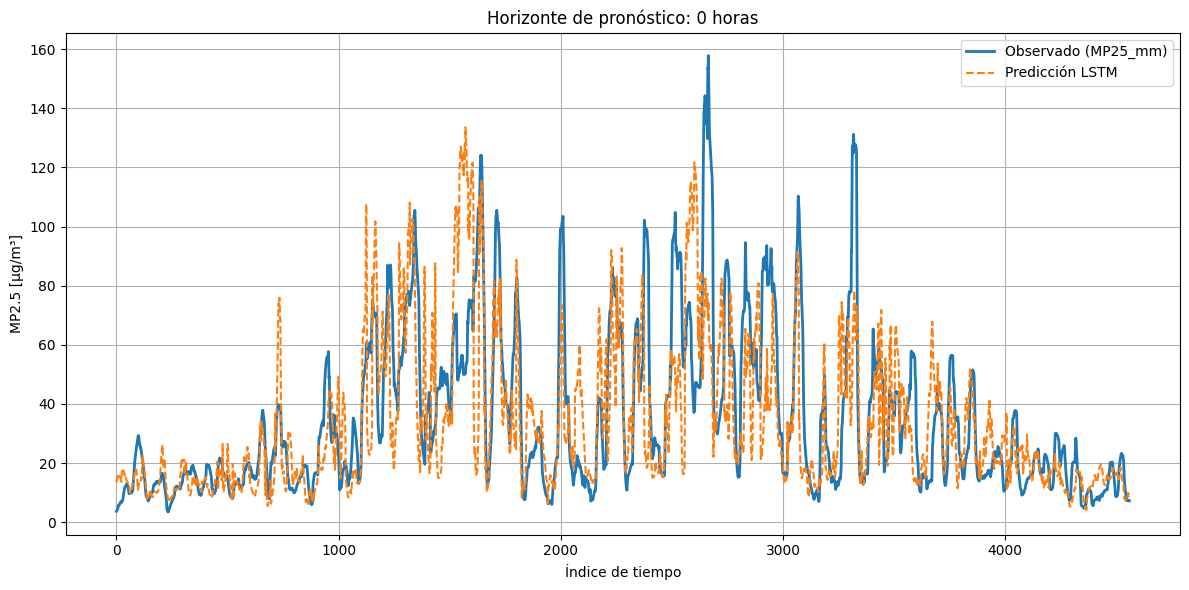

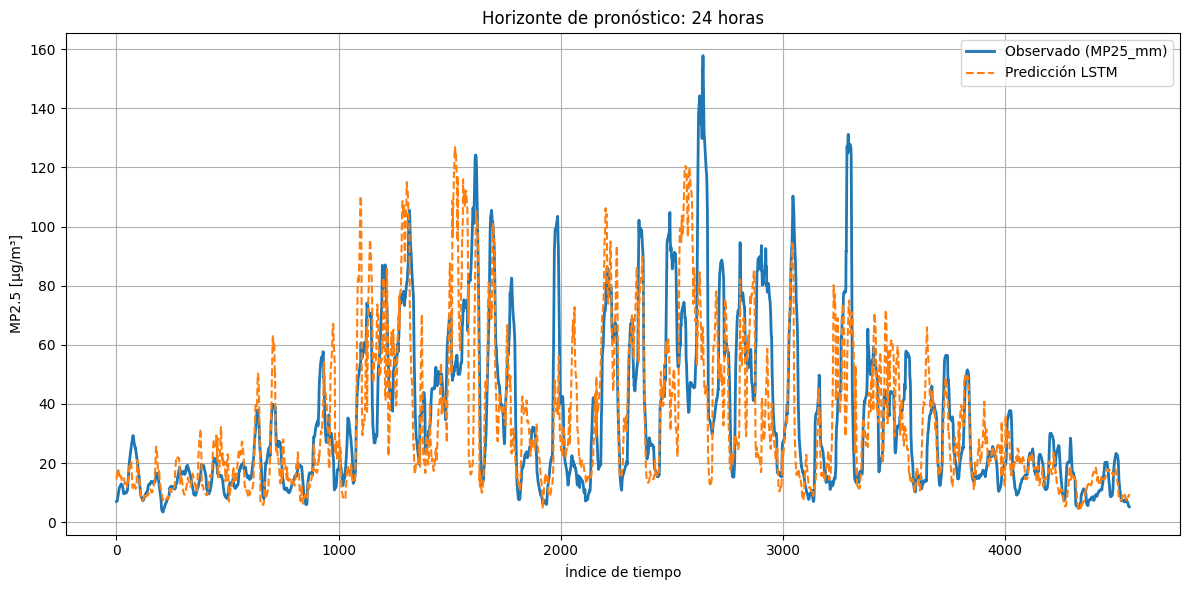

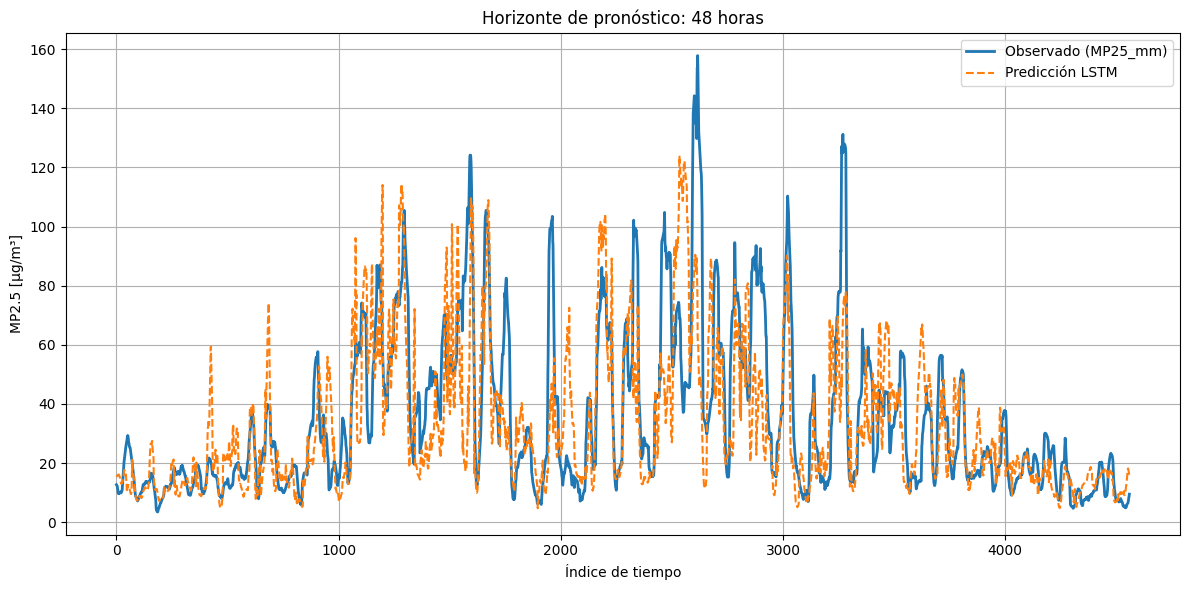

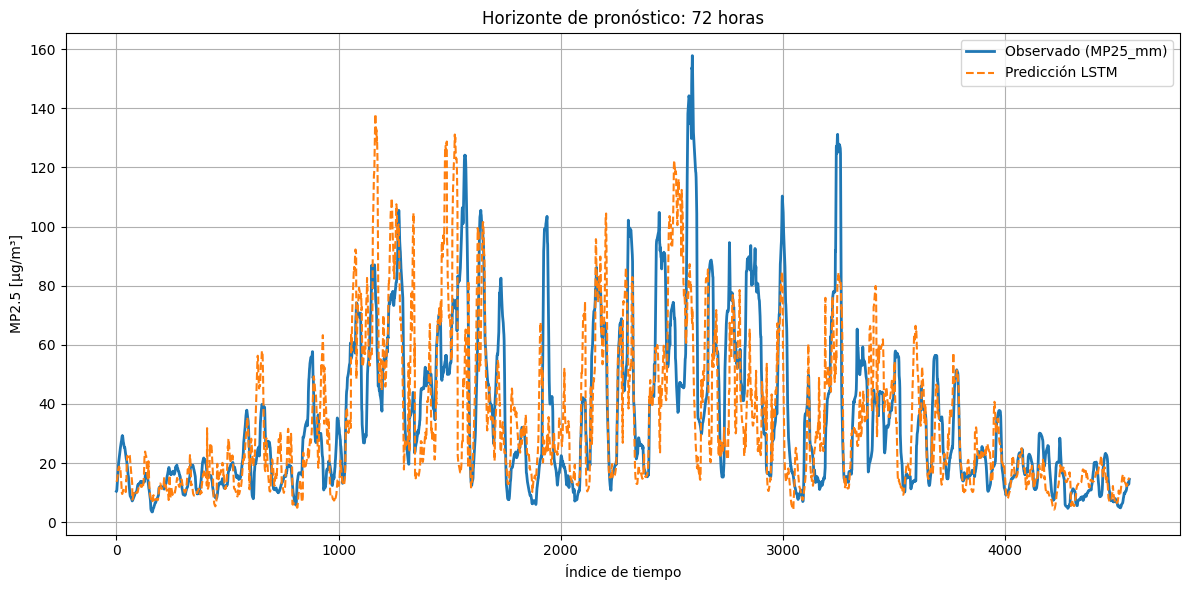

In [24]:
import matplotlib.pyplot as plt

for i, _df in enumerate([df_test0, df_test1, df_test2, df_test3]):
    plt.figure(figsize=(12, 6))
    plt.plot(_df['MP25_mm'].values, label='Observado (MP25_mm)', linewidth=2)
    plt.plot(_df['pred'].values, label='Predicción LSTM', linestyle='--')
    plt.xlabel('Índice de tiempo')
    plt.ylabel('MP2.5 [µg/m³]')
    plt.title(f'Horizonte de pronóstico: {i * 24} horas')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [25]:
print(df_test[['horizonte', 'MP25_mm', 'pred']].head(10))
print(df_test['pred'].describe())


       horizonte  MP25_mm       pred
36384          0     3.67  13.452169
36385          0     3.83  14.013869
36386          0     3.96  14.101602
36387          0     4.04  14.457548
36388          0     4.21  14.756019
36389          0     4.38  15.032676
36390          0     4.50  15.318038
36391          0     5.04  15.715551
36392          0     5.21  15.998379
36393          0     5.71  15.858594
count    18240.000000
mean        33.514523
std         25.075468
min          3.913083
25%         15.080187
50%         24.089270
75%         45.565237
max        138.100266
Name: pred, dtype: float64


In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
import numpy as np
def get_metricas(y_true_log, y_pred_lin, nombre=""):
    # Asegurar que no haya NaNs
    mask = ~(np.isnan(y_true_log) | np.isnan(y_pred_lin))
    y_true_log = y_true_log[mask]
    y_pred_lin = y_pred_lin[mask]

    # Convertir a espacio lineal
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(np.log1p(y_pred_lin))  # En caso de que haya valores negativos o 0

    # Cálculo de métricas
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    r, _ = pearsonr(y_true, y_pred)
    fb = 2 * (y_pred.mean() - y_true.mean()) / (y_pred.mean() + y_true.mean()) if (y_pred.mean() + y_true.mean()) != 0 else np.nan

    print(f"--- {nombre} ---")
    print(f"RMSE     : {rmse:.2f}")
    print(f"MAE      : {mae:.2f}")
    print(f"R²       : {r2:.3f}")
    print(f"FB       : {fb:.3f}")
    print(f"Pearson r: {r:.3f}")
    print()

    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'fb': fb,
        'r': r
    }


In [33]:
metricas_h0 = get_metricas(df_test0['MP25_log'].values, np.log1p(df_test0['pred'].values), nombre="Horizonte 0")
metricas_h1 = get_metricas(df_test1['MP25_log'].values, np.log1p(df_test1['pred'].values), nombre="Horizonte 1")
metricas_h2 = get_metricas(df_test2['MP25_log'].values, np.log1p(df_test2['pred'].values), nombre="Horizonte 2")
metricas_h3 = get_metricas(df_test3['MP25_log'].values, np.log1p(df_test3['pred'].values), nombre="Horizonte 3")


--- Horizonte 0 ---
RMSE     : 41.85
MAE      : 32.13
R²       : -1.356
FB       : -1.658
Pearson r: 0.676

--- Horizonte 1 ---
RMSE     : 41.84
MAE      : 32.13
R²       : -1.356
FB       : -1.658
Pearson r: 0.686

--- Horizonte 2 ---
RMSE     : 41.85
MAE      : 32.14
R²       : -1.354
FB       : -1.660
Pearson r: 0.700

--- Horizonte 3 ---
RMSE     : 41.84
MAE      : 32.12
R²       : -1.353
FB       : -1.658
Pearson r: 0.673

